In [2]:
# 1️⃣ Import Libraries
# =============================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.video import r3d_18
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [3]:
# 2️⃣ Device & Class Names
# =============================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
class_names = ["no_theft", "store_theft"]


Using device: cpu


In [4]:
# 3️⃣ Define VideoDataset (same as training)
# =============================
class VideoDataset(Dataset):
    def __init__(self, root_dir, num_frames=16, transform=None):
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.transform = transform
        self.videos = []
        self.labels = []
        classes = {"no_theft": 0, "store_theft": 1}
        for cls_name, label in classes.items():
            cls_dir = os.path.join(root_dir, cls_name)
            if not os.path.exists(cls_dir):
                continue
            for video_name in os.listdir(cls_dir):
                video_path = os.path.join(cls_dir, video_name)
                if os.path.isdir(video_path):
                    self.videos.append(video_path)
                    self.labels.append(label)
    def __len__(self):
        return len(self.videos)
    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = self.labels[idx]
        frames = []
        frame_files = sorted(os.listdir(video_path))[:self.num_frames]
        for f in frame_files:
            img = Image.open(os.path.join(video_path, f)).convert("RGB")
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        video_tensor = torch.stack(frames)
        return video_tensor, torch.tensor(label, dtype=torch.long)


In [5]:
# 4️⃣ Define Transforms
# =============================
frame_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

In [6]:
# 5️⃣ Load Saved Model
# =============================
model = r3d_18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("pretrained_video_model.pth", map_location=device))
model.to(device)
model.eval()
print("✅ Model loaded successfully!")



✅ Model loaded successfully!


C:\Users\Alieldin\AppData\Local\Temp\ipykernel_30568\2098897867.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pretrained_video_model.

In [7]:
# 6️⃣ Prepare Test Dataset & Loader
# =============================
test_dataset = VideoDataset("split_data/test", num_frames=16, transform=frame_transforms)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [8]:
# 7️⃣ Evaluate Test Accuracy
# =============================
all_labels = []
all_preds = []

with torch.no_grad():
    for videos, labels in test_loader:
        videos = videos.permute(0,2,1,3,4).float().to(device)
        labels = labels.to(device)
        outputs = model(videos)
        _, predicted = torch.max(outputs,1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
test_acc = (all_preds == all_labels).mean() * 100
print(f"✅ Test Accuracy: {test_acc:.2f}%")

✅ Test Accuracy: 87.85%


In [9]:
# 8️⃣ Classification Report
# =============================
print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))



📊 Classification Report:

              precision    recall  f1-score   support

    no_theft     0.8852    0.8710    0.8780       124
 store_theft     0.8720    0.8862    0.8790       123

    accuracy                         0.8785       247
   macro avg     0.8786    0.8786    0.8785       247
weighted avg     0.8786    0.8785    0.8785       247



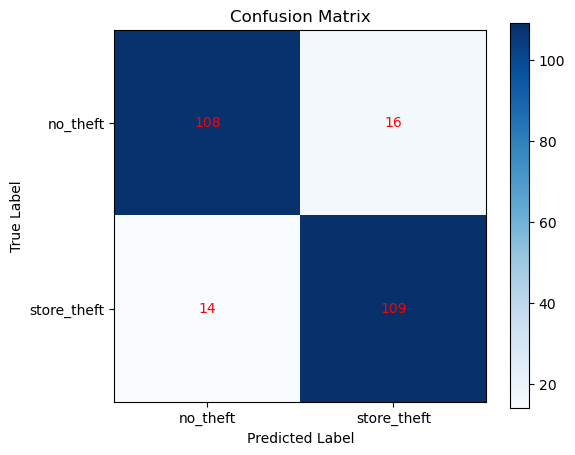

In [10]:
# 9️⃣ Confusion Matrix
# =============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Add numbers
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center", color="red")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

✅ Accuracy for no_theft: 87.10%
✅ Accuracy for store_theft: 88.62%


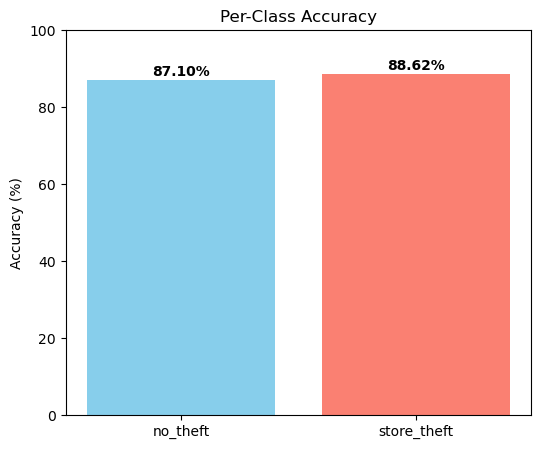

In [11]:
# 🔟 Per-Class Accuracy Bar Chart
# =============================
per_class_acc = []
for i, cls in enumerate(class_names):
    cls_mask = all_labels == i
    cls_correct = (all_preds[cls_mask] == all_labels[cls_mask]).sum()
    cls_total = cls_mask.sum()
    acc = cls_correct / cls_total * 100
    per_class_acc.append(acc)
    print(f"✅ Accuracy for {cls}: {acc:.2f}%")

plt.figure(figsize=(6,5))
plt.bar(class_names, per_class_acc, color=["skyblue","salmon"])
plt.ylabel("Accuracy (%)")
plt.ylim(0,100)
plt.title("Per-Class Accuracy")
for i, v in enumerate(per_class_acc):
    plt.text(i, v+1, f"{v:.2f}%", ha="center", fontweight='bold')
plt.show()


In [12]:
# 11️⃣ Predict a Single New Video
# =============================
def predict_video(video_path, num_frames=16):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        print(f"⚠️ Empty video: {video_path}")
        return None, None
    indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)
        img = frame_transforms(img)
        frames.append(img)
    cap.release()
    if len(frames) < num_frames:
        print(f"⚠️ Not enough frames in {video_path}")
        return None, None
    video_tensor = torch.stack(frames).permute(1,0,2,3).unsqueeze(0).float().to(device)
    with torch.no_grad():
        outputs = model(video_tensor)
        probs = F.softmax(outputs, dim=1)[0]
        pred_idx = torch.argmax(probs).item()
        confidence = probs[pred_idx].item() * 100
        label = class_names[pred_idx]
    return label, confidence

# Example:
video_path = r"D:\cellula\task3\dataset\store_theft\shop_lifter_51.mp4"  # replace with your video
label, conf = predict_video(video_path)
if label is not None:
    print(f"🎬 Prediction: {label.upper()} ({conf:.2f}% confident)")

🎬 Prediction: STORE_THEFT (56.73% confident)


In [13]:
# Example:
video_path = r"D:\cellula\task3\dataset\store_theft\shop_lifter_55.mp4"  # replace with your video
label, conf = predict_video(video_path)
if label is not None:
    print(f"🎬 Prediction: {label.upper()} ({conf:.2f}% confident)")

🎬 Prediction: STORE_THEFT (51.07% confident)


In [15]:
import csv

# Folder containing new videos
input_folder = r"D:\cellula\task3\dataset\no_theft"  # change this to your folder
output_csv = "video_predictions.csv"

# Get all video files
videos = [f for f in os.listdir(input_folder) if f.endswith(('.mp4', '.avi', '.mov'))]

# Prepare CSV
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["video_name", "predicted_label", "confidence"])

    # Loop through each video
    for v in videos:
        video_path = os.path.join(input_folder, v)
        label, conf = predict_video(video_path)
        if label is not None:
            writer.writerow([v, label, f"{conf:.2f}"])
            print(f"🎬 {v:<30} → {label.upper():<12} ({conf:.2f}%)")

print(f"\n✅ Predictions saved to '{output_csv}'")


🎬 shop_lifter_n_0.mp4            → NO_THEFT     (64.82%)
🎬 shop_lifter_n_0_1.mp4          → NO_THEFT     (64.82%)
🎬 shop_lifter_n_1.mp4            → NO_THEFT     (64.24%)
🎬 shop_lifter_n_10.mp4           → NO_THEFT     (66.24%)
🎬 shop_lifter_n_100.mp4          → STORE_THEFT  (53.21%)
🎬 shop_lifter_n_100_1.mp4        → STORE_THEFT  (53.21%)
🎬 shop_lifter_n_101.mp4          → STORE_THEFT  (52.11%)
🎬 shop_lifter_n_101_1.mp4        → STORE_THEFT  (52.11%)
🎬 shop_lifter_n_102.mp4          → STORE_THEFT  (53.09%)
🎬 shop_lifter_n_102_1.mp4        → STORE_THEFT  (53.09%)
🎬 shop_lifter_n_103.mp4          → STORE_THEFT  (52.05%)
🎬 shop_lifter_n_103_1.mp4        → STORE_THEFT  (52.05%)
🎬 shop_lifter_n_104.mp4          → STORE_THEFT  (51.33%)
🎬 shop_lifter_n_104_1.mp4        → STORE_THEFT  (51.33%)
🎬 shop_lifter_n_105.mp4          → STORE_THEFT  (53.23%)
🎬 shop_lifter_n_105_1.mp4        → STORE_THEFT  (53.23%)
🎬 shop_lifter_n_106.mp4          → STORE_THEFT  (55.04%)
🎬 shop_lifter_n_106_1.mp4      